## Long Short-Term Memory (LSTMs)

In [48]:
# Import all required libraries
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [27]:
# Import feature and target columns
df = pickle.load(open("../../common/pima.p", "rb"))
target_columns = pickle.load(open("../../common/feature_cols.p", "rb"))
split_size = pickle.load(open("../../common/split_size.p", "rb"))
n_past = pickle.load(open("../../common/n_past.p", "rb"))
n_future = pickle.load(open("../../common/n_future.p", "rb"))

### Perform Cross Validation

### Train the model

In [28]:
# Create function to prepare data sequences
def create_sequences(input_data, n_past, n_future, target_column_index):
    X, y = [], []
    for window_start in range(len(input_data) - n_past - n_future + 1):
        past_end = window_start + n_past
        future_end = past_end + n_future
        X.append(input_data[window_start:past_end, :])
        y.append(input_data[past_end:future_end, target_column_index])
    return np.array(X), np.array(y)

In [49]:
def print_score(y_test, y_pred):
    y_test_flat = y_test.flatten()
    y_pred_flat = y_pred.flatten()
    
    # Calculate metrics
    mae = mean_absolute_error(y_test_flat, y_pred_flat)
    mse = mean_squared_error(y_test_flat, y_pred_flat)
    rmse = np.sqrt(mse) # root mean squared error
    r2 = r2_score(y_test_flat, y_pred_flat)

    print('MAE:', mae)
    print('MSE:', mse)
    print('RMSE:', rmse)
    print('R^2:', r2)

In [29]:
# Initialize a dictionary to store the scalers
scalers = {}

# Scale each target column individually and store the scaler
scaled_df = df[target_columns].copy()
for i, target_col in enumerate(target_columns):
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_df[target_col] = scaler.fit_transform(df[[target_col]].values)
    scalers[target_col] = scaler

# Convert the DataFrame back to a numpy array
scaled_df = scaled_df.values

# Prepare the training and test sets
train_size = int(len(scaled_df) * split_size)
test_size = len(scaled_df) - train_size
train, test = scaled_df[:train_size, :], scaled_df[train_size:, :]

# Get test statuses data
statuses_df = df[["status"]].copy().values
status_size = train_size + n_past
status_test = statuses_df[status_size:, :].copy()
statuses = status_test[:, -1]

In [30]:
# Train models and make initial predictions
models = {}
initial_predictions = {}
for i, target_col in enumerate(target_columns):
    # Prepare sequences
    X_train, y_train = create_sequences(train, n_past, n_future, i)
    X_test, y_test = create_sequences(test, n_past, n_future, i)

    # Design LSTM model
    model = Sequential()
    model.add(LSTM(64, activation='relu', input_shape=(n_past, X_train.shape[2]), return_sequences=True))
    model.add(LSTM(32, activation='relu', return_sequences=False))
    model.add(Dense(n_future))
    model.compile(optimizer='adam', loss='mse')

    # Train the model
    model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)
    models[target_col] = model

    # Initial prediction
    initial_predictions[target_col] = model.predict(X_test)

14/14 [==============================] - 0s 5ms/step


### Predict the value

In [31]:
# Recursive multi-step forecast
n_steps = len(test) - n_past
predictions = {col: [] for col in target_columns}
for step in range(n_steps):
    current_seq = test[step:step + n_past, :]
    next_seq = current_seq.copy()  # copy of the current sequence to be updated with predictions
    for i, target_col in enumerate(target_columns):
        model = models[target_col]
        pred = model.predict(current_seq.reshape(1, n_past, -1))[0,0]
        predictions[target_col].append(pred)
        next_seq[-1, i] = pred  # update next sequence with the prediction
    current_seq = next_seq  # use the sequence updated with predictions for the next step

1/1 [==============================] - 0s 31ms/step


### Visualize the model

MAE: 0.045639782036686276
MSE: 0.003417120344883665
RMSE: 0.058456140352264666
R^2: 0.5320891170462341


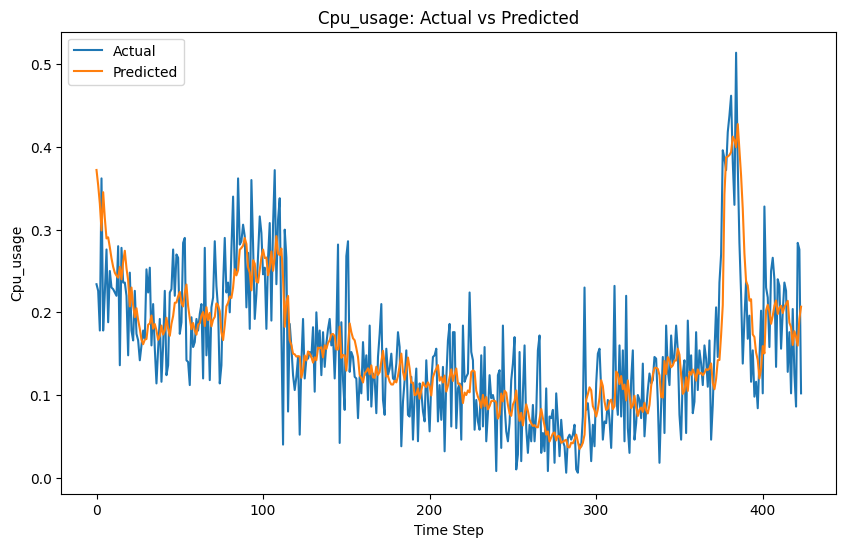

MAE: 0.0013185620634060965
MSE: 4.639803775253603e-06
RMSE: 0.002154020374846441
R^2: 0.5555673797654799


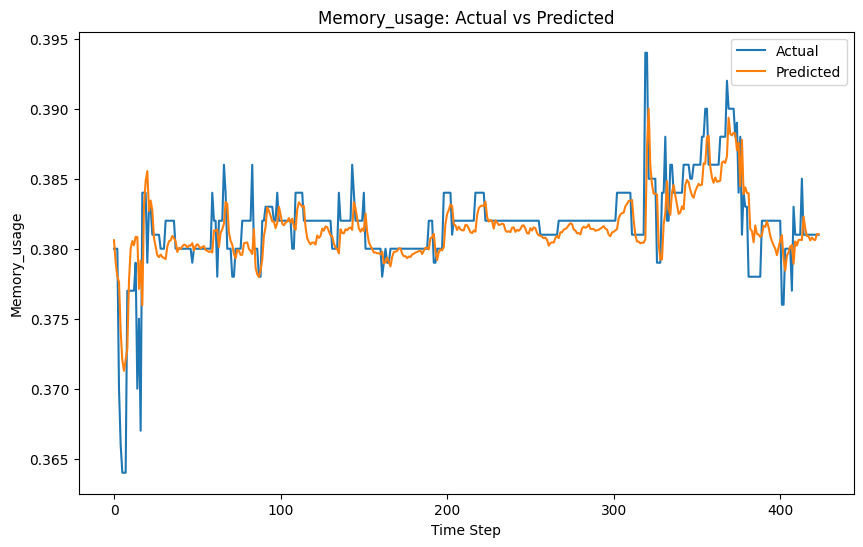

MAE: 2413.687121178969
MSE: 9734053.44516899
RMSE: 3119.944461872517
R^2: 0.3463722917284491


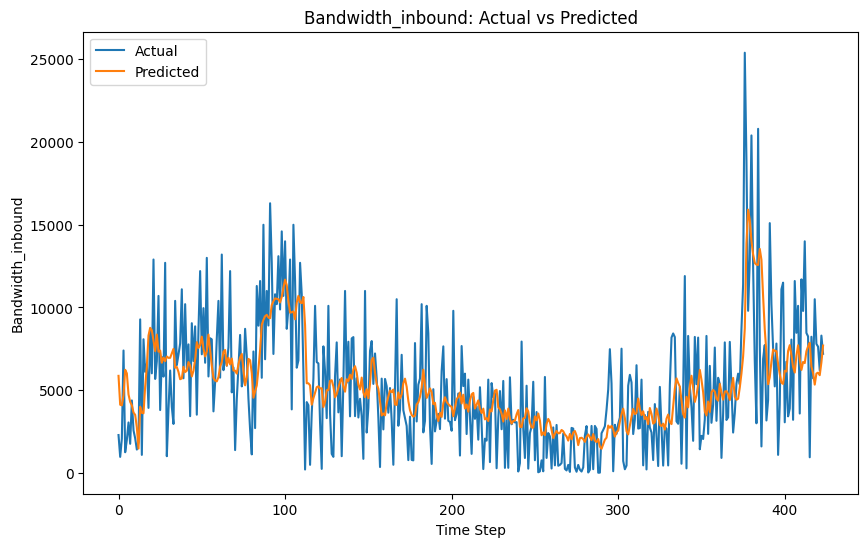

MAE: 2143.986126708984
MSE: 7472059.285492378
RMSE: 2733.5067743637255
R^2: 0.30890250214764514


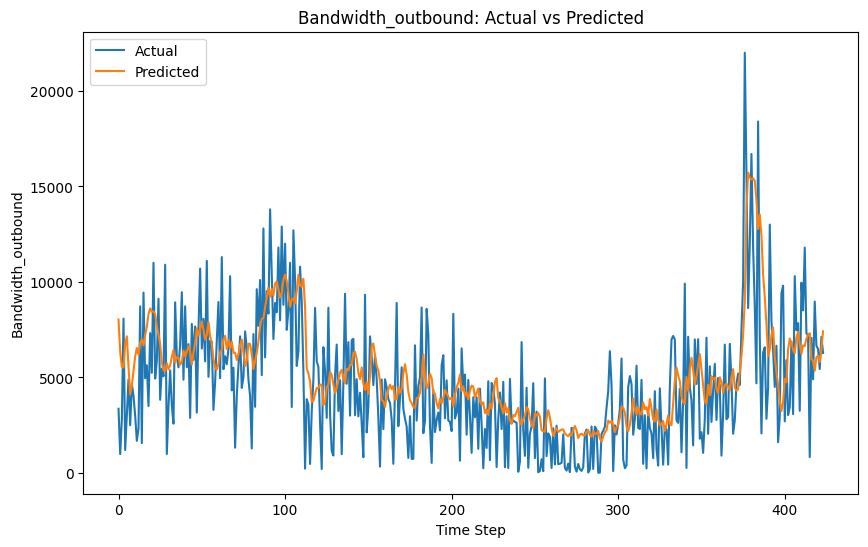

MAE: 0.0675801614320503
MSE: 0.011539032009800955
RMSE: 0.10741988647266834
R^2: 0.9823611120417309


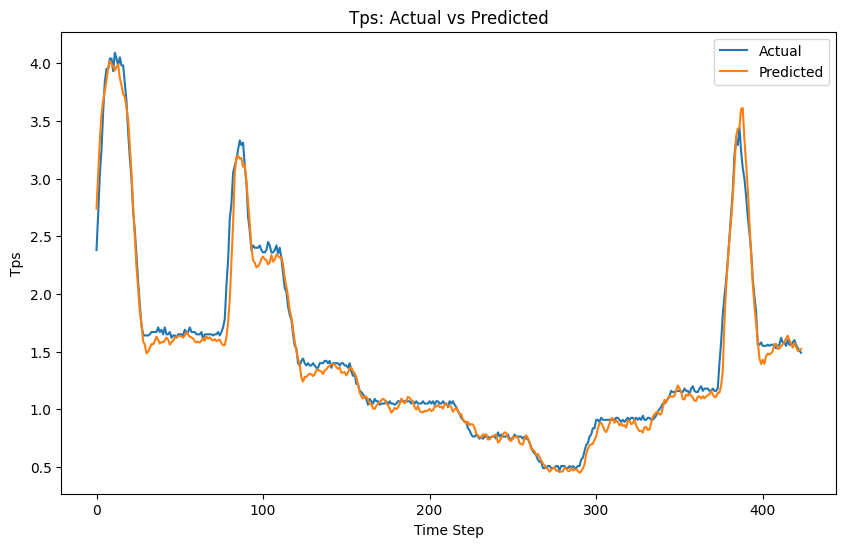

MAE: 57.35300733458321
MSE: 10199.383865912616
RMSE: 100.9919990192917
R^2: 0.9838703382370722


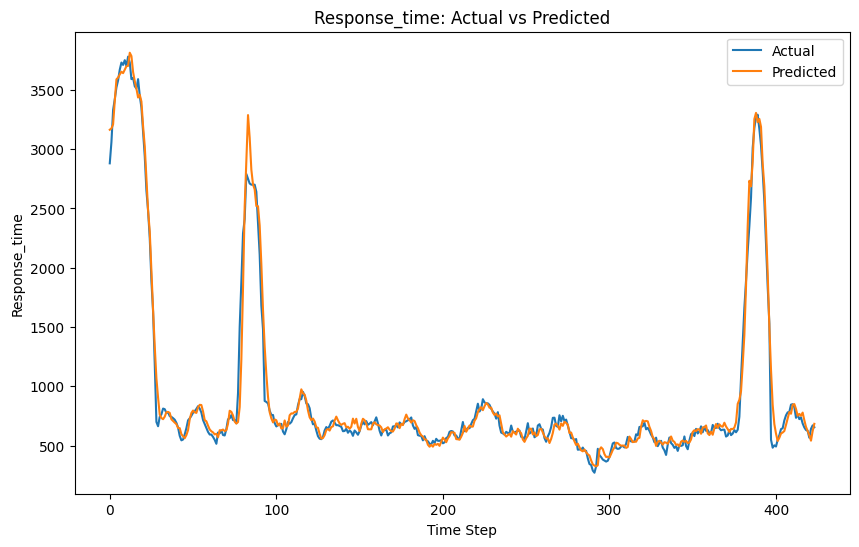

In [50]:
# Plot actual vs predicted
for i, target_col in enumerate(target_columns):
    actual_val = scalers[target_col].inverse_transform(test[n_past:, i].reshape(-1,1))
    predicted_val = scalers[target_col].inverse_transform(np.array(predictions[target_col]).reshape(-1,1))
    print_score(actual_val, predicted_val)

    plt.figure(figsize=(10, 6))
    plt.plot(actual_val, label='Actual')
    plt.plot(predicted_val, label='Predicted')
    plt.title(f'{target_col.capitalize()}: Actual vs Predicted')
    plt.ylabel(f'{target_col.capitalize()}')
    plt.xlabel('Time Step')
    plt.legend()
    plt.show()

In [33]:
inverse_transform_predictions = {}

for i, target_col in enumerate(target_columns):
    inverse_transform_predictions[target_col] = scalers[target_col].inverse_transform(np.array(predictions[target_col]).reshape(-1,1)).flatten()

# Let's convert it to DataFrame to check the result
df_inverse_predictions = pd.DataFrame(inverse_transform_predictions)
np_predictions = pd.DataFrame(df_inverse_predictions.values, columns=target_columns)

print(np_predictions.head())
print(len(np_predictions))

   cpu_usage  memory_usage  bandwidth_inbound  bandwidth_outbound       tps   
0   0.372173      0.380604        5867.265137         8033.869141  2.739594  \
1   0.353824      0.378999        4122.653320         6333.491699  3.040211   
2   0.331423      0.378041        4081.874756         5562.584473  3.327207   
3   0.299020      0.377606        4691.460938         5516.505859  3.555280   
4   0.345295      0.374125        6233.452148         6730.020020  3.677181   

   response_time  
0    3163.096191  
1    3174.584229  
2    3208.956787  
3    3405.765869  
4    3588.287598  
424


### Export the model

In [34]:
pickle.dump(models, open('../../models/multivariate/lstm/models.p', 'wb'))
pickle.dump(scalers, open('../../models/multivariate/lstm/_scalers.p', 'wb'))
pickle.dump(np_predictions, open('../../models/multivariate/lstm/_predictions_result.p', 'wb'))
pickle.dump(statuses, open('../../models/multivariate/lstm/_statuses_test.p', 'wb'))